## ECG Simulation & Event Injection:
- We simulate a 60‑second ECG at 500 Hz and randomly “inject” 5 events (each lasting 200 samples). For each sliding window (of length 1000 samples), if any event occurs in the forecast horizon that follows, we set the label to 1.
##- **Dataset Definition:** The ECGEventDataset creates input–label pairs where each input is a window of past ECG samples and the label is binary (1 or 0) depending on whether an event occurs in the forecast horizon.
## Model Architectures:
Four models are provided:
- **LSTMClassifier:** Uses an LSTM to capture sequential dependencies.
- **TCNClassifier:** Uses dilated convolutions (with ReLU activations) along with global average pooling.
- **TransformerClassifier:** Projects inputs into a higher-dimensional space, passes them through transformer encoder layers, then averages the output to classify.
- **HybridCNNLSTMClassifier:** Applies a convolutional layer with pooling to extract local features before feeding them into an LSTM for classification.
## Training & Evaluation:
A standard training loop minimizes binary cross entropy loss; accuracy is computed by thresholding the predicted probability at 0.5. Each model is trained for a set number of epochs and then evaluated on a held‑out validation set.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Import PyTorch Geometric modules
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Choose device: GPU if available, otherwise CPU (note: "mps" is for macOS)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


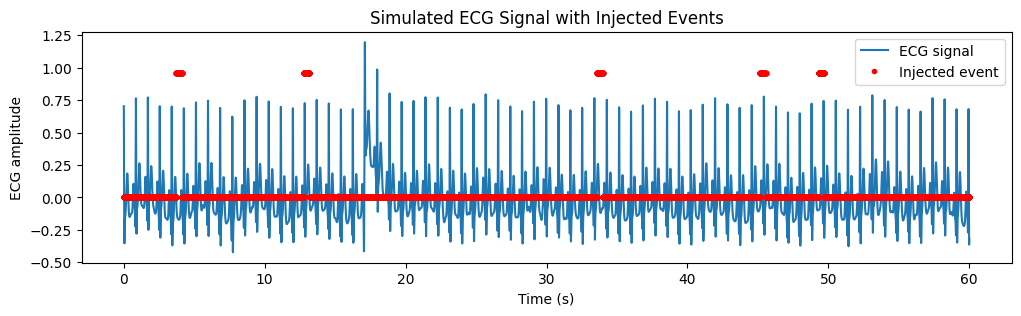

In [9]:
####################################
# 1. Simulate ECG Signal and Inject Events
####################################
fs = 500                   # Sampling frequency (Hz)
duration = 60              # Duration in seconds
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=fs, noise=0.05)
ecg_signal = np.array(ecg_signal)  # Ensure it's a NumPy array
signal_length = len(ecg_signal)

# Define window length and forecast horizon (in samples)
window_size = 1000         # Past 2 seconds (if fs=500, then 1000 samples)
forecast_horizon = 1000    # Look 2 seconds ahead

# Create a synthetic event indicator array.
event_indicator = np.zeros(signal_length)
num_events = 5             # Number of events to inject
event_duration = 200       # Duration (in samples) that an event lasts

for i in range(num_events):
    event_start = np.random.randint(window_size, signal_length - forecast_horizon - event_duration)
    event_indicator[event_start:event_start + event_duration] = 1

# Visualize a segment of the ECG with injected events
plt.figure(figsize=(12, 3))
time_axis = np.arange(signal_length) / fs
plt.plot(time_axis, ecg_signal, label="ECG signal")
plt.plot(time_axis, event_indicator * (np.max(ecg_signal) * 0.8), 'r.', label="Injected event")
plt.xlabel("Time (s)")
plt.ylabel("ECG amplitude")
plt.title("Simulated ECG Signal with Injected Events")
plt.legend()
plt.show()


In [10]:
####################################
# 2. Create Dataset for Event Prediction
####################################
class ECGEventDataset(Dataset):
    """
    This dataset creates a sliding window of past ECG samples with a corresponding binary label.
    The label is 1 if any event is present in the forecast horizon immediately following the window, else 0.
    """
    def __init__(self, ecg_signal, event_indicator, window_size, forecast_horizon):
        self.ecg_signal = ecg_signal
        self.event_indicator = event_indicator
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.n_samples = len(ecg_signal) - window_size - forecast_horizon + 1

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        X = self.ecg_signal[idx: idx + self.window_size]
        label = 1.0 if np.any(self.event_indicator[idx + self.window_size: idx + self.window_size + self.forecast_horizon]) else 0.0
        return torch.tensor(X, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Instantiate the dataset and create train/validation splits
dataset = ECGEventDataset(ecg_signal, event_indicator, window_size, forecast_horizon)
print("Dataset size:", len(dataset))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Dataset size: 28001


In [4]:
####################################
# 3. Define Models for Event Detection
####################################

# 3.1 LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM expects input shape (batch, seq_len, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, window_size)
        x = x.unsqueeze(-1)  # (batch, window_size, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        last_hidden = out[:, -1, :]   # last time step hidden state
        logit = self.fc(last_hidden)
        return torch.sigmoid(logit).squeeze(-1)

# 3.2 TCN Classifier (using dilated convolutions)
class TCNClassifier(nn.Module):
    def __init__(self, num_channels=32, num_levels=3):
        super(TCNClassifier, self).__init__()
        layers = []
        in_channels = 1  # input signal channel
        kernel_size = 3
        for i in range(num_levels):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation  # to keep output length same as input
            layers.append(nn.Conv1d(in_channels,
                                    num_channels,
                                    kernel_size,
                                    padding=padding,
                                    dilation=dilation))
            layers.append(nn.ReLU())
            in_channels = num_channels
        self.network = nn.Sequential(*layers)
        # Global average pooling followed by a fully connected layer for binary classification
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        # x: (batch, window_size)
        x = x.unsqueeze(1)  # (batch, 1, window_size)
        out = self.network(x)  # (batch, num_channels, L)
        out = out[:, :, :x.size(2)]  # trim to original length if needed (due to padding)
        # Global average pooling over time dimension
        out = out.mean(dim=2)  # (batch, num_channels)
        logit = self.fc(out)
        return torch.sigmoid(logit).squeeze(-1)

# 3.3 Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, window_size, d_model=64, nhead=8, num_layers=2):
        super(TransformerClassifier, self).__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, window_size)
        x = x.unsqueeze(-1)  # (batch, window_size, 1)
        x = self.input_proj(x)  # (batch, window_size, d_model)
        # Transformer expects shape (seq_len, batch, d_model)
        x = x.transpose(0, 1)  # (window_size, batch, d_model)
        transformer_out = self.transformer_encoder(x)  # (window_size, batch, d_model)
        # Take the mean over the sequence dimension
        pool = transformer_out.mean(dim=0)  # (batch, d_model)
        logit = self.fc(pool)
        return torch.sigmoid(logit).squeeze(-1)

# 3.4 Hybrid Model: CNN + LSTM Classifier
class HybridCNNLSTMClassifier(nn.Module):
    def __init__(self, window_size, cnn_channels=16, hidden_size=32, num_layers=1):
        super(HybridCNNLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, cnn_channels, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # reduces length by factor 2
        # LSTM takes in sequence features from CNN (cnn_channels features per time step)
        self.lstm = nn.LSTM(cnn_channels, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, window_size)
        x = x.unsqueeze(1)   # (batch, 1, window_size)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)      # (batch, cnn_channels, window_size/2)
        x = x.transpose(1, 2) # (batch, window_size/2, cnn_channels)
        lstm_out, (hn, _) = self.lstm(x)  # (batch, seq_len, hidden_size)
        logit = self.fc(hn[-1])           # use the last hidden state
        return torch.sigmoid(logit).squeeze(-1)

# 3.5. Hybrid Model: Transformer + LSTM Classifier
class HybridTransformerLSTMClassifier(nn.Module):
    def __init__(self, window_size, d_model=64, nhead=8, transformer_layers=2,
                 lstm_hidden_size=32, lstm_layers=1, dropout=0.1):
        """
        Parameters:
          window_size (int): Number of time steps in the input sequence.
          d_model (int): Dimension of the input projection and Transformer features.
          nhead (int): Number of heads in the Transformer encoder.
          transformer_layers (int): Number of stacked Transformer encoder layers.
          lstm_hidden_size (int): Number of features in the LSTM hidden state.
          lstm_layers (int): Number of stacked LSTM layers.
          dropout (float): Dropout probability.
        """
        super(HybridTransformerLSTMClassifier, self).__init__()

        # Input projection: map the one-dimensional input into a d_model-dimensional space.
        self.input_proj = nn.Linear(1, d_model)

        # Transformer encoder layers.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # LSTM to further capture sequential dynamics.
        self.lstm = nn.LSTM(input_size=d_model,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers,
                            batch_first=True)

        # Fully-connected output: maps the LSTM's last hidden state to a probability.
        self.fc = nn.Linear(lstm_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Input:
            x: Tensor of shape (batch_size, window_size)
        Output:
            prob: Tensor of shape (batch_size) representing the predicted probability.
        """
        # x shape: (batch_size, window_size)
        # Unsqueeze to (batch_size, window_size, 1) since we have one feature (ECG value).
        x = x.unsqueeze(-1)
        # Project input to d_model dimension.
        x = self.input_proj(x)  # now shape: (batch_size, window_size, d_model)

        # Transformer expects input shape (sequence_length, batch_size, d_model).
        x = x.transpose(0, 1)  # (window_size, batch_size, d_model)
        x = self.transformer_encoder(x)  # Output shape remains (window_size, batch_size, d_model)

        # Convert back to shape (batch_size, window_size, d_model).
        x = x.transpose(0, 1)

        # Pass through LSTM.
        lstm_out, (hn, cn) = self.lstm(x)  # lstm_out: (batch_size, window_size, lstm_hidden_size)
        # Use the last hidden state of the last LSTM layer as the representation.
        last_hidden = hn[-1]  # (batch_size, lstm_hidden_size)

        # Fully connected layer to predict the event probability.
        logits = self.fc(last_hidden)  # (batch_size, 1)
        prob = self.sigmoid(logits).squeeze(-1)  # (batch_size)
        return prob

####################################
# 4. Training and Evaluation Functions
####################################
def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss /= total
        train_acc = train_correct / total

        # Evaluation on validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
                preds = (outputs >= 0.5).float()
                val_correct += (preds == y_val).sum().item()
                total_val += y_val.size(0)
        val_loss /= total_val
        val_acc = val_correct / total_val

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")
    return model

####################################
# 5. Instantiate, Train, and Evaluate Each Model
####################################
num_epochs = 10  # For demonstration; adjust as necessary
learning_rate = 0.001

# Dictionary to hold models and their names for iteration.
model_dict = {
    "LSTMClassifier": LSTMClassifier(),
    "TCNClassifier": TCNClassifier(),
    "TransformerClassifier": TransformerClassifier(window_size=window_size),
    "HybridCNNLSTMClassifier": HybridCNNLSTMClassifier(window_size=window_size),
    "HybridTransformerLSTMClassifier": HybridTransformerLSTMClassifier(window_size=window_size)
}

# Iterate through each model type, train, and evaluate.
for model_name, model in model_dict.items():
    print("\nTraining model:", model_name)
    model = model.to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss since output is probability
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Final evaluation
    model.eval()
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = (outputs >= 0.5).float()
            val_correct += (preds == y_val).sum().item()
            total_val += y_val.size(0)
    val_acc = val_correct / total_val
    print(f"Final Validation Accuracy for {model_name}: {val_acc:.4f}")


Training model: LSTMClassifier


/Users/linh/Downloads/ECGPreprocessor/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10: Train Loss 0.5173, Train Acc 0.7861 | Val Loss 0.5073, Val Acc 0.7940
Epoch 2/10: Train Loss 0.5127, Train Acc 0.7901 | Val Loss 0.5054, Val Acc 0.7940
Epoch 3/10: Train Loss 0.5123, Train Acc 0.7901 | Val Loss 0.5058, Val Acc 0.7940
Epoch 4/10: Train Loss 0.5120, Train Acc 0.7901 | Val Loss 0.5046, Val Acc 0.7940
Epoch 5/10: Train Loss 0.5122, Train Acc 0.7901 | Val Loss 0.5102, Val Acc 0.7940
Epoch 6/10: Train Loss 0.5129, Train Acc 0.7901 | Val Loss 0.5062, Val Acc 0.7940
Epoch 7/10: Train Loss 0.5122, Train Acc 0.7901 | Val Loss 0.5135, Val Acc 0.7940
Epoch 8/10: Train Loss 0.5136, Train Acc 0.7901 | Val Loss 0.5071, Val Acc 0.7940
Epoch 9/10: Train Loss 0.5125, Train Acc 0.7901 | Val Loss 0.5050, Val Acc 0.7940
Epoch 10/10: Train Loss 0.5111, Train Acc 0.7901 | Val Loss 0.5072, Val Acc 0.7940
Final Validation Accuracy for LSTMClassifier: 0.7940

Training model: TCNClassifier
Epoch 1/10: Train Loss 0.4944, Train Acc 0.7901 | Val Loss 0.4829, Val Acc 0.7940
Epoch 2/10: T

### LSTM (Long Short-Term Memory) Models:
LSTMs have been the traditional workhorse for time series and sequential data. They excel at learning temporal dependencies and handling variable-length sequences. In many biomedical applications, LSTMs have shown success in modeling ECG data for event prediction. However, they might struggle with very long sequences due to computational inefficiencies and can require careful tuning to avoid overfitting, especially if the available dataset is limited.
### Temporal Convolutional Networks (TCNs):
TCNs use dilated convolutions to capture long-range dependencies and are often more parallelizable and faster to train than recurrent networks. They have shown state-of-the-art performance in many sequence tasks while being less sensitive to hyperparameter changes. For heart failure prediction, where capturing subtle changes in ECG morphology over extended periods is important, TCNs offer robust performance with a relatively simpler training process.
### Transformer Models:
Transformer architectures, relying on self-attention mechanisms, have recently gained popularity in time series forecasting and event prediction due to their ability to model long-term dependencies without the recurrence bottleneck. They can be especially effective if you have a large, annotated dataset, as they typically require more data than LSTM or TCN models to reach their full potential. That said, they also demand more computational power and careful regularization to avoid overfitting.
### Hybrid Models (e.g., CNN-LSTM):
In a hybrid approach, convolutional layers can first extract local features from the raw ECG—capturing spatial (or local temporal) features—before feeding this into an LSTM (or even a Transformer) that learns how these features evolve over time. This combination can sometimes offer the best of both worlds, especially if your ECG data benefits from both local feature extraction and long-term dependency modelling. 
### Which Should You Choose?
- **If you have a large dataset and significant computational resources:**
A Transformer-based model might be a promising choice. Its self-attention mechanism can capture complex, long-range dependencies in ECG data that are key to predicting heart failure events. Recent studies have demonstrated that when provided ample data, Transformers can outperform classical RNN-based models in various time series tasks.
- **If your dataset is moderate or if you require a model that is efficient and easier to tune:**
TCNs could provide a strong balance. They are efficient, benefit from robust gradient flow (due to their convolutional structure), and can capture both short- and long-term patterns effectively.
- **If interpretability and well-established techniques are paramount:**
LSTMs have been widely studied in the biomedical domain, and their outputs (especially when combined with attention mechanisms) can sometimes be easier to interpret clinically. A hybrid CNN-LSTM model might also be a good compromise in these cases.
### Brief Considerations
- Ultimately, there is no one-size-fits-all answer. I recommend experimenting with a couple of these architectures—perhaps starting with a TCN or a hybrid CNN-LSTM for baseline performance. If you have access to a large, diverse dataset and the computational budget, try a Transformer-based model as well. Beyond selecting a promising model architecture, pay close attention to rigorous preprocessing, proper segmentation of the ECG signal, and validation on clinically relevant hold-out datasets.


- By comparing validation performance (e.g., using metrics such as AUC, sensitivity, and specificity) and taking into account the interpretability and deployment constraints of your application, you can make a more informed decision on the most appropriate model for predicting future heart failure events from ECG data.



# Now, let's try Graph Neural Networks-based model to tackle into the current issue
## GNN-Only Model for Cardiac Event Prediction
In many scenarios, you may represent your ECG data (or features extracted per heartbeat) as a graph. For example, each heart beat can be a node (with features such as morphology, timing, or HRV metrics) with edges connecting neighboring beats (or beats exhibiting similar characteristics). The following model uses two graph convolution layers (GCNConv) and a global pooling operation to produce a graph-level prediction (e.g., the probability of a future cardiac event)

In [5]:
class GNNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        """
        in_channels (int): Number of features per node.
        hidden_channels (int): Dimension of hidden representations.
        num_classes (int): Number of output classes (use 1 for binary classification with a sigmoid).
        """
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # A fully connected layer to produce graph-level output.
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        """
        x: Node feature matrix of shape (num_nodes, in_channels).
        edge_index: Graph connectivity (COO format) tensor.
        batch: Batch vector which assigns each node to a specific example in the batch.
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        # Aggregate nodes into a graph-level representation.
        x = global_mean_pool(x, batch)  # shape: (batch_size, hidden_channels)
        out = self.fc(x)
        return torch.sigmoid(out).squeeze(-1)

# Example usage with dummy data:
if __name__ == '__main__':
    # Suppose we have a graph with 100 nodes, each with 10 features.
    num_nodes = 100
    in_channels = 10
    hidden_channels = 32
    num_classes = 1  # binary classification

    # Dummy node features.
    x = torch.randn((num_nodes, in_channels))
    # Dummy edge_index (example connectivity)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    # Suppose we have 5 graphs in the batch, and nodes are assigned to graphs randomly.
    batch = torch.randint(0, 5, (num_nodes,))

    model = GNNClassifier(in_channels, hidden_channels, num_classes)
    output = model(x, edge_index, batch)
    print("GNN model output shape:", output.shape)  # Expected: (batch_size,)

GNN model output shape: torch.Size([5])


## Hybrid GNN + LSTM Model (Graph-Sequential)
There are situations where you might want to capture not only the local relationships of beats (via a GNN) but also the sequential evolution of these relationships over time. For example, if you extract features per beat and then order these beats by time, you can treat each graph as a sequence. In the following hybrid model, we first use the GNN to obtain node (beat) embeddings and then feed the ordered embeddings into an LSTM for sequential modeling.

Assumption: Here we assume that—within each graph (or patient record)—the nodes are ordered by time. In practice, you might build or sort the nodes such that the ordering corresponds to the temporal sequence (and pad sequences if necessary).

In [6]:
class HybridGNNLSTMClassifier(torch.nn.Module):
    def __init__(self, in_channels, gnn_hidden_channels, lstm_hidden_size, lstm_layers, num_classes):
        """
        in_channels (int): Number of input features per node.
        gnn_hidden_channels (int): Hidden dimension for the GNN layers.
        lstm_hidden_size (int): Hidden dimension for the LSTM.
        lstm_layers (int): Number of LSTM layers.
        num_classes (int): Number of output classes (1 for binary classification).
        """
        super(HybridGNNLSTMClassifier, self).__init__()
        # Two GCN layers to get node embeddings.
        self.conv1 = GCNConv(in_channels, gnn_hidden_channels)
        self.conv2 = GCNConv(gnn_hidden_channels, gnn_hidden_channels)

        # LSTM to capture the temporal evolution of node embeddings.
        self.lstm = nn.LSTM(
            input_size=gnn_hidden_channels,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )
        # A fully-connected layer from the LSTM's last hidden state to output.
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x, edge_index, batch):
        """
        x: Node feature matrix (num_nodes, in_channels).
        edge_index: Graph connectivity.
        batch: Batch vector assigning nodes to graphs.

        This model assumes that for each graph in the batch, the nodes are in the temporal order.
        It also assumes that each graph has the same number of nodes (or sequences are padded appropriately).
        """
        # Apply GNN layers.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # Rearrange node embeddings into sequences per graph.
        batch_size = int(batch.max().item()) + 1
        node_counts = torch.bincount(batch)
        # For simplicity assume each graph has the same number of nodes, T.
        T = node_counts[0].item()  # e.g., number of beats per record
        # It is important that nodes for each graph are ordered by time.
        # Here, we assume nodes in x are sorted appropriately according to `batch`.
        x = x.view(batch_size, T, -1)  # Shape: (batch_size, T, gnn_hidden_channels)

        # Process the sequence with LSTM.
        lstm_out, (hn, _) = self.lstm(x)
        # Use the last hidden state of the LSTM as a sequence representation.
        last_hidden = hn[-1]  # Shape: (batch_size, lstm_hidden_size)
        out = self.fc(last_hidden)
        return torch.sigmoid(out).squeeze(-1)

# Example usage for the hybrid model:
if __name__ == '__main__':
    # Assume 100 nodes overall with each graph having 20 nodes, and there are 5 graphs in the batch.
    num_nodes = 100
    in_channels = 10
    gnn_hidden_channels = 32
    lstm_hidden_size = 16
    lstm_layers = 1
    num_classes = 1

    # Dummy node features.
    x = torch.randn((num_nodes, in_channels))
    # Dummy edge_index for connectivity (this example uses random graph connections).
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    # Create batch assignment: suppose 5 graphs, each with 20 nodes.
    batch = torch.cat([torch.full((20,), i) for i in range(5)], dim=0)

    model = HybridGNNLSTMClassifier(in_channels, gnn_hidden_channels, lstm_hidden_size, lstm_layers, num_classes)
    output = model(x, edge_index, batch)
    print("Hybrid model output shape:", output.shape)  # Expected: (batch_size,) which is (5,)

Hybrid model output shape: torch.Size([5])


In [ ]:
####################################
# 3. Define a Helper to Convert a Sliding Window to a Graph
####################################
def convert_to_graph(ecg_window, label):
    """
    Converts a 1D ECG sliding window (tensor of shape (window_size,))
    to a PyTorch Geometric Data object:
      - Each time point is a node with one feature.
      - A simple undirected chain graph is created by connecting consecutive nodes.
    """
    # Node features: reshape the sliding window to (window_size, 1)
    x = ecg_window.unsqueeze(1)  # shape: (window_size, 1)

    # Create chain edges: for each node i, connect to i+1 (both directions for an undirected graph)
    num_nodes = x.size(0)
    edge_list = []
    for i in range(num_nodes - 1):
        edge_list.append([i, i + 1])
        edge_list.append([i + 1, i])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # shape: (2, num_edges)

    # Create a Data object. We also store the label as a tensor of shape (1,)
    data = Data(x=x, edge_index=edge_index, y=label.unsqueeze(0))
    return data

####################################
# 4. Define the GNN-only and Hybrid (GNN+LSTM) Models
####################################
# GNN-only model definition
class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        """
        in_channels: Number of features per node (1 for our ECG amplitude)
        hidden_channels: Dimension of hidden features
        num_classes: Number of outputs (use 1 for binary classification)
        """
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        # Global pooling: aggregate node features into a graph-level representation.
        x = global_mean_pool(x, batch)  # shape: (batch_size, hidden_channels)
        logits = self.fc(x)             # shape: (batch_size, num_classes)
        return torch.sigmoid(logits).squeeze(-1)

# Hybrid GNN + LSTM model definition
class HybridGNNLSTMClassifier(nn.Module):
    def __init__(self, in_channels, gnn_hidden_channels, lstm_hidden_size, lstm_layers, num_classes):
        """
        in_channels: Number of features per node
        gnn_hidden_channels: Hidden dimension for GNN layers
        lstm_hidden_size: Hidden dimension for LSTM
        lstm_layers: Number of LSTM layers
        num_classes: Number of outputs (1 for binary classification)
        """
        super(HybridGNNLSTMClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, gnn_hidden_channels)
        self.conv2 = GCNConv(gnn_hidden_channels, gnn_hidden_channels)
        self.lstm = nn.LSTM(
            input_size=gnn_hidden_channels,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        # Assume for each graph, the nodes are ordered in time (as in our chain graph)
        # First, separate node embeddings for each graph.
        batch_size = int(batch.max().item()) + 1
        node_counts = torch.bincount(batch)
        # Here we assume all graphs have the same number of nodes: T = window_size
        T = node_counts[0].item()
        # Reshape to (batch_size, T, gnn_hidden_channels)
        x = x.view(batch_size, T, -1)
        lstm_out, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]  # shape: (batch_size, lstm_hidden_size)
        logits = self.fc(last_hidden)
        return torch.sigmoid(logits).squeeze(-1)

####################################
# 5. Define Training and Evaluation Helper Functions
####################################
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    criterion = nn.BCELoss()
    num_batches = 0

    for X_batch, y_batch in dataloader:
        batch_graphs = []
        for x, y in zip(X_batch, y_batch):
            data = convert_to_graph(x, y)
            batch_graphs.append(data)
        batch_data = Batch.from_data_list(batch_graphs).to(device)

        optimizer.zero_grad()
        output = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        loss = criterion(output, batch_data.y.float().view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = (output > 0.5).float()
        acc = (preds == batch_data.y.float().view(-1)).sum().item() / len(y_batch)
        epoch_acc += acc
        num_batches += 1

    return epoch_loss / num_batches, epoch_acc / num_batches

def evaluate(model, dataloader, device):
    model.eval()
    epoch_loss = 0.0
    epoch_acc = 0.0
    criterion = nn.BCELoss()
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            batch_graphs = []
            for x, y in zip(X_batch, y_batch):
                data = convert_to_graph(x, y)
                batch_graphs.append(data)
            batch_data = Batch.from_data_list(batch_graphs).to(device)
            output = model(batch_data.x, batch_data.edge_index, batch_data.batch)
            loss = criterion(output, batch_data.y.float().view(-1))
            epoch_loss += loss.item()
            preds = (output > 0.5).float()
            acc = (preds == batch_data.y.float().view(-1)).sum().item() / len(y_batch)
            epoch_acc += acc
            num_batches += 1
    return epoch_loss / num_batches, epoch_acc / num_batches

####################################
# 6. Initialize the Model and Train
####################################
# To train the GNN-only model, uncomment the following lines:
model = GNNClassifier(in_channels=1, hidden_channels=32, num_classes=1)
# Alternatively, to train the hybrid GNN+LSTM model, uncomment:
model = HybridGNNLSTMClassifier(in_channels=1, gnn_hidden_channels=32,
                                lstm_hidden_size=16, lstm_layers=1, num_classes=1)




# model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 10

# for epoch in range(num_epochs):
#     train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
#     val_loss, val_acc = evaluate(model, val_loader, device)
#     print(f"Epoch {epoch+1}/{num_epochs}: Train loss={train_loss:.4f}, Train acc={train_acc:.4f} | Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")

####################################
# 6. Train Multiple GNN-based Models using a Dictionary
####################################
# Create a dictionary with your models
model_dict = {
    "GNN_only": GNNClassifier(in_channels=1, hidden_channels=32, num_classes=1),
    "Hybrid_GNN_LSTM": HybridGNNLSTMClassifier(in_channels=1, gnn_hidden_channels=32,
                                                 lstm_hidden_size=16, lstm_layers=1, num_classes=1)
}

# Set training parameters
num_epochs = 1
lr = 0.001

# Dictionary to store results
results = {}

for model_name, model in model_dict.items():
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f"\nTraining {model_name} model...")

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, device)
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}: "
              f"Train loss={train_loss:.4f}, Train acc={train_acc:.4f} | "
              f"Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")

    # Store final validation performance in the results dictionary
    results[model_name] = {"val_loss": val_loss, "val_acc": val_acc}

print("\nFinal Evaluation Results:")
for name, metrics in results.items():
    print(f"Model {name}: Val Loss={metrics['val_loss']:.4f} / Val Acc={metrics['val_acc']:.4f}")


Training GNN_only model...


## Discussion
### GNN-Only Models:
GNNs can be particularly effective when the data naturally form a graph structure—for example, when the relationships or similarity between heartbeats (or between different sensor signals) is important for predicting an event. Models like GCNs, Graph Attention Networks (GATs), or even more advanced architectures can capture such relations.
### Hybrid GNN + Sequential Models:
In some cases, you not only want to capture relationships using a graph but also wish to explicitly model temporal evolution. The hybrid approach first uses a GNN to obtain embeddings from relational structures (e.g., per-beat features) and then uses a sequential model (e.g., LSTM or Transformer) to learn temporal dependencies across these events. This combination can capture both the structural and temporal complexities underlying the prediction of heart failure or other cardiac events.
### When to Use Each:
- Use a pure GNN if your data’s key information is contained in the pairwise relationships or network structure between features, beats, or sensors.
- Use a hybrid approach if you have time-ordered events (e.g., sequential beats, multi-modal time series) and you want to benefit from both relational (graph) and sequential (LSTM/Transformer) modeling.

Both paradigms are under active research for biomedical applications, and combining them can yield improved performance on complex prediction tasks.

If you have further questions or need additional modifications (for example, incorporating attention mechanisms or a Transformer instead of an LSTM), feel free to ask!